In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import tensorflow
import os
import cv2
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU, GlobalAveragePooling2D, Rescaling
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn import metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications import ResNet50
from skimage.transform import resize
from keras.applications.resnet50 import preprocess_input

# Split accuracy comparision

In [ ]:
!unzip  -q /content/drive/MyDrive/GoogleCollab/Data/GTZAN/spectrograms/Spectrograms_with_test_train_split/Split_2_randomstate_24/spectrograms_original.zip -d "/content/spectrograms_original_1"
!unzip  -q /content/drive/MyDrive/GoogleCollab/Data/GTZAN/spectrograms/Spectrograms_with_test_train_split/Split_2_randomstate_24/spectrograms_split_1s.zip -d "/content/spectrograms_split_1s_1"
!unzip  -q /content/drive/MyDrive/GoogleCollab/Data/GTZAN/spectrograms/Spectrograms_with_test_train_split/Split_2_randomstate_24/spectrograms_split_3s.zip -d "/content/spectrograms_split_3s_1"
!unzip  -q /content/drive/MyDrive/GoogleCollab/Data/GTZAN/spectrograms/Spectrograms_with_test_train_split/Split_2_randomstate_24/spectrograms_split_5s.zip -d "/content/spectrograms_split_5s_1"
!unzip  -q /content/drive/MyDrive/GoogleCollab/Data/GTZAN/spectrograms/Spectrograms_with_test_train_split/Split_2_randomstate_24/spectrograms_split_10s.zip -d "/content/spectrograms_split_10s_1"
!unzip  -q /content/drive/MyDrive/GoogleCollab/Data/GTZAN/spectrograms/Spectrograms_with_test_train_split/Split_2_randomstate_24/spectrograms_split_20s.zip -d "/content/spectrograms_split_20s_1"

In [ ]:
checkpoint_dir = "/content/drive/MyDrive/GoogleCollab/Data/GTZAN/checkpoints/Split_3/"
models_dict = {}
model_prefix = "_best_model_"
history_prefix = "_history_"

for directory in os.listdir(checkpoint_dir):
  if directory.startswith("Model_"):
    best_model_path = os.path.join(checkpoint_dir, directory)
    for file_name in os.listdir(best_model_path):
      if file_name.startswith(directory + model_prefix):
        split_type_name = file_name.split(directory + model_prefix)[1].split(".")[0]

        print(split_type_name)
        train_spectrograms_dir = f'/content/spectrograms_{split_type_name}/train'
        test_spectrograms_dir = f'/content/spectrograms_{split_type_name}/test'

        train_ds = tensorflow.keras.utils.image_dataset_from_directory(
        train_spectrograms_dir,
        label_mode='categorical',
        seed=123,
        image_size=(600, 300))

        test_ds = tensorflow.keras.utils.image_dataset_from_directory(
        test_spectrograms_dir,
        label_mode='categorical',
        seed=123,
        image_size=(600, 300))

        model_split_name = directory + ": " + file_name.split(directory + model_prefix)[1].split(".")[0]
        best_model = tensorflow.keras.models.load_model(checkpoint_dir + directory + "/" + file_name)

        y_test_all = []
        y_pred_all = []

        for images, labels in test_ds:
          predict_results = best_model.predict(images, verbose=None)
          y_pred = np.argmax(predict_results, axis=1)
          y_pred_all.extend(y_pred)
          y_test_all.extend(labels.numpy())

        y_pred_all = np.array(y_pred_all)
        y_test_all = np.array(y_test_all)

        y_test_indices = np.argmax(y_test_all, axis=1) if y_test_all.ndim > 1 else y_test_all

        for history in os.listdir(best_model_path):
          if history.startswith(directory + history_prefix + split_type_name):
            history = history

        history = f"{checkpoint_dir}{directory}/{directory}{history_prefix}{split_type_name}.npy"

        model_dict = {'y_pred': y_pred_all, 'y_test': y_test_indices, 'history': history}
        models_dict[str(model_split_name)] = model_dict

split_20s
Found 798 files belonging to 10 classes.
Found 200 files belonging to 10 classes.


split_10s
Found 2387 files belonging to 10 classes.
Found 598 files belonging to 10 classes.


split_5s
Found 4781 files belonging to 10 classes.
Found 1198 files belonging to 10 classes.


split_3s
Found 7973 files belonging to 10 classes.
Found 1998 files belonging to 10 classes.


original
Found 798 files belonging to 10 classes.
Found 200 files belonging to 10 classes.


split_1s
Found 23933 files belonging to 10 classes.
Found 5998 files belonging to 10 classes.


split_20s
Found 798 files belonging to 10 classes.
Found 200 files belonging to 10 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


split_10s
Found 2387 files belonging to 10 classes.
Found 598 files belonging to 10 classes.


split_5s
Found 4781 files belonging to 10 classes.
Found 1198 files belonging to 10 classes.


split_3s
Found 7973 files belonging to 10 classes.
Found 1998 files belonging to 10 classes.


original
Found 798 files belonging to 10 classes.
Found 200 files belonging to 10 classes.


split_1s
Found 23933 files belonging to 10 classes.
Found 5998 files belonging to 10 classes.


In [ ]:
from collections import OrderedDict

def custom_sort_key(key):
    order = {
        'original': 0,
        '1s': 1,
        '3s': 2,
        '5s': 3,
        '10s': 4,
        '20s': 5
    }
    return order.get(key.split('_')[-1], len(order))

sorted_models_dict = OrderedDict(sorted(models_dict.items(), key=lambda item: custom_sort_key(item[0])))

In [ ]:
np.save('split_3_accuracy_comparision_dict.npy', sorted_models_dict)

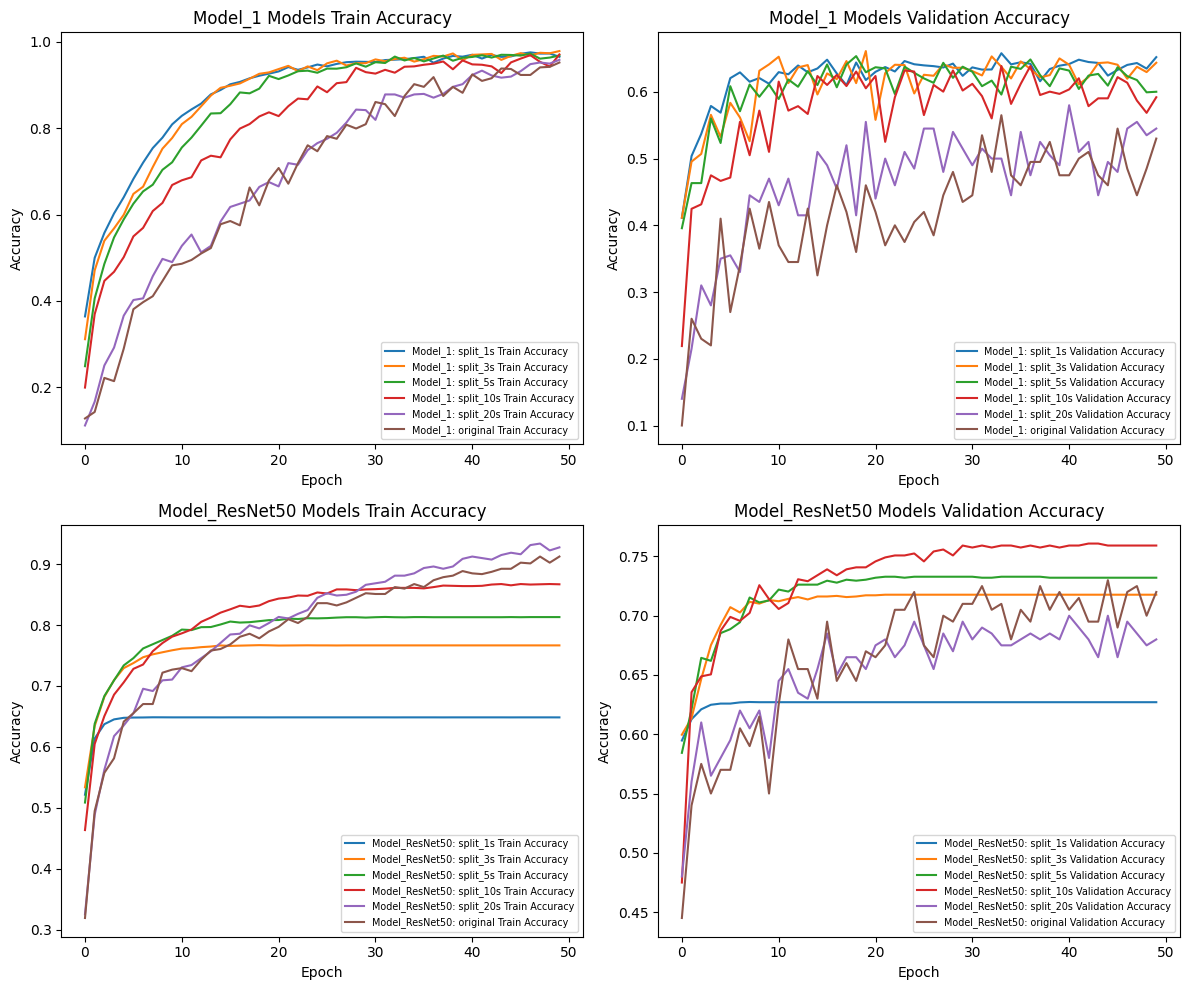

In [ ]:
def plot_combined_history(model_prefix, models_dict, axes):
    ax1, ax2 = axes

    for model in models_dict:
        if model.startswith(model_prefix):
            history = np.load(models_dict.get(model).get('history'), allow_pickle='TRUE').item()
            history['accuracy'] = history['accuracy'][:50]
            history['val_accuracy'] = history['val_accuracy'][:50]
            ax1.plot(history['accuracy'], label=f'{model} Train Accuracy')
            ax2.plot(history['val_accuracy'], label=f'{model} Validation Accuracy')

    ax1.set_title(f'{model_prefix} Models Train Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(fontsize="x-small", loc='lower right')

    ax2.set_title(f'{model_prefix} Models Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend(fontsize="x-small", loc='lower right')


models_dict = np.load("/content/drive/MyDrive/GoogleCollab/Data/GTZAN/checkpoints/Split_3/split_3_accuracy_comparision_dict.npy", allow_pickle=True)
models_dict = models_dict.item()

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

plot_combined_history('Model_1', models_dict, axes[0])
plot_combined_history('Model_ResNet50', models_dict, axes[1])

plt.tight_layout()
plt.savefig('combined_splits.png')
plt.show()

In [ ]:
for model in models_dict:
  history = np.load(models_dict[model]['history'], allow_pickle='TRUE').item()
  history['accuracy'] = history['accuracy']
  history['val_accuracy'] = history['val_accuracy']

  max_train_acc = max(history['accuracy'])
  max_val_acc = max(history['val_accuracy'])

  print("Model: %s Train acc: %.2f Val acc: %.2f" % (model, max_train_acc, max_val_acc))

Model: Model_1: split_1s Train acc: 0.98 Val acc: 0.60
Model: Model_ResNet50: split_1s Train acc: 0.66 Val acc: 0.59
Model: Model_1: split_3s Train acc: 0.97 Val acc: 0.59
Model: Model_ResNet50: split_3s Train acc: 0.78 Val acc: 0.67
Model: Model_1: split_5s Train acc: 0.97 Val acc: 0.61
Model: Model_ResNet50: split_5s Train acc: 0.82 Val acc: 0.70
Model: Model_1: split_10s Train acc: 0.97 Val acc: 0.62
Model: Model_ResNet50: split_10s Train acc: 0.87 Val acc: 0.70
Model: Model_1: split_20s Train acc: 0.95 Val acc: 0.52
Model: Model_ResNet50: split_20s Train acc: 0.91 Val acc: 0.70
Model: Model_1: original Train acc: 0.94 Val acc: 0.58
Model: Model_ResNet50: original Train acc: 0.93 Val acc: 0.70


In [ ]:
models_dict = np.load("/content/drive/MyDrive/GoogleCollab/Data/GTZAN/checkpoints/Split_1/split_1_accuracy_comparision_dict.npy", allow_pickle=True)
models_dict = models_dict.item()

spectogram_dir = '/content/drive/MyDrive/GoogleCollab/Data/GTZAN/old_spectrograms/mel_spectrograms'
classes = np.load(os.path.join(spectogram_dir, 'classes.npy'))

for model in models_dict:
  y_pred = models_dict.get(model).get('y_pred')
  y_test = models_dict.get(model).get('y_test')
  accuracy = accuracy_score(y_test, y_pred)
  metrics_f1_score = metrics.f1_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred))
  # report = classification_report(y_test, y_pred, target_names=classes)
  print(str(model) + " statistics")
  print(f'Accuracy: {accuracy:.4f}')
  print(f'F1 Score: {metrics_f1_score}'+'\n')

Model_1: split_1s statistics
Accuracy: 0.6316
F1 Score: 0.6316389996660153

Model_ResNet50: split_1s statistics
Accuracy: 0.6155
F1 Score: 0.6115718848478777

Model_1: split_3s statistics
Accuracy: 0.6430
F1 Score: 0.6427906214490859

Model_ResNet50: split_3s statistics
Accuracy: 0.6870
F1 Score: 0.6850440150592457

Model_1: split_5s statistics
Accuracy: 0.6525
F1 Score: 0.6519134486036394

Model_ResNet50: split_5s statistics
Accuracy: 0.7093
F1 Score: 0.7090793274313621

Model_1: split_10s statistics
Accuracy: 0.5980
F1 Score: 0.5902456997278748

Model_ResNet50: split_10s statistics
Accuracy: 0.7219
F1 Score: 0.7213162119319706

Model_1: split_20s statistics
Accuracy: 0.5550
F1 Score: 0.548878523753048

Model_ResNet50: split_20s statistics
Accuracy: 0.6850
F1 Score: 0.6863937786002449

Model_1: original statistics
Accuracy: 0.6100
F1 Score: 0.6016946223275409

Model_ResNet50: original statistics
Accuracy: 0.6850
F1 Score: 0.6861479315158486



# MEL vs MFCC accuracy comparision

In [ ]:
!unzip  -q /content/drive/MyDrive/GoogleCollab/Data/GTZAN/spectrograms/Spectrograms_with_test_train_split/spectrograms_mel.zip -d "/content/spectrograms_mel"
!unzip  -q /content/drive/MyDrive/GoogleCollab/Data/GTZAN/spectrograms/Spectrograms_with_test_train_split/spectrograms_mfcc.zip -d "/content/spectrograms_mfcc"


In [ ]:
checkpoint_dir = "/content/drive/MyDrive/GoogleCollab/Data/GTZAN/checkpoints/mel_vs_mfcc/"
models_dict = {}
model_prefix = "_best_model_original_"
history_prefix = "_history_original_"

for directory in os.listdir(checkpoint_dir):
  if directory.startswith("Model_"):
    best_model_path = os.path.join(checkpoint_dir, directory)
    for file_name in os.listdir(best_model_path):
      if file_name.startswith(directory + model_prefix):
        spectrogram_type_name = file_name.split(directory + model_prefix)[1].split(".")[0]

        print(spectrogram_type_name)
        train_spectrograms_dir = f'/content/spectrograms_{spectrogram_type_name}/train'
        test_spectrograms_dir = f'/content/spectrograms_{spectrogram_type_name}/test'

        train_ds = tensorflow.keras.utils.image_dataset_from_directory(
        train_spectrograms_dir,
        label_mode='categorical',
        seed=123,
        image_size=(600, 300))

        test_ds = tensorflow.keras.utils.image_dataset_from_directory(
        test_spectrograms_dir,
        label_mode='categorical',
        seed=123,
        image_size=(600, 300))

        model_split_name = directory + ": " + file_name.split(directory + model_prefix)[1].split(".")[0]

        if directory.startswith("Model_3"):
          best_model = tensorflow.keras.models.load_model(checkpoint_dir + directory + "/" + file_name, custom_objects={'LeakyReLU': LeakyReLU})
        else:
          best_model = tensorflow.keras.models.load_model(checkpoint_dir + directory + "/" + file_name)

        y_test_all = []
        y_pred_all = []

        for images, labels in test_ds:
          predict_results = best_model.predict(images, verbose=None)
          y_pred = np.argmax(predict_results, axis=1)
          y_pred_all.extend(y_pred)
          y_test_all.extend(labels.numpy())

        y_pred_all = np.array(y_pred_all)
        y_test_all = np.array(y_test_all)

        y_test_indices = np.argmax(y_test_all, axis=1) if y_test_all.ndim > 1 else y_test_all

        for history in os.listdir(best_model_path):
          if history.startswith(directory + history_prefix + spectrogram_type_name):
            history = history

        history = f"{checkpoint_dir}{directory}/{directory}{history_prefix}{spectrogram_type_name}.npy"

        model_dict = {'y_pred': y_pred_all, 'y_test': y_test_indices, 'history': history}
        models_dict[str(model_split_name)] = model_dict

mel
Found 798 files belonging to 10 classes.
Found 200 files belonging to 10 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


mfcc
Found 798 files belonging to 10 classes.
Found 200 files belonging to 10 classes.


mel
Found 798 files belonging to 10 classes.
Found 200 files belonging to 10 classes.


mfcc
Found 798 files belonging to 10 classes.
Found 200 files belonging to 10 classes.


mel
Found 798 files belonging to 10 classes.
Found 200 files belonging to 10 classes.


mfcc
Found 798 files belonging to 10 classes.
Found 200 files belonging to 10 classes.


mel
Found 798 files belonging to 10 classes.
Found 200 files belonging to 10 classes.


mfcc
Found 798 files belonging to 10 classes.
Found 200 files belonging to 10 classes.


In [ ]:
np.save('model_accuracy_comparision_dict.npy', models_dict)

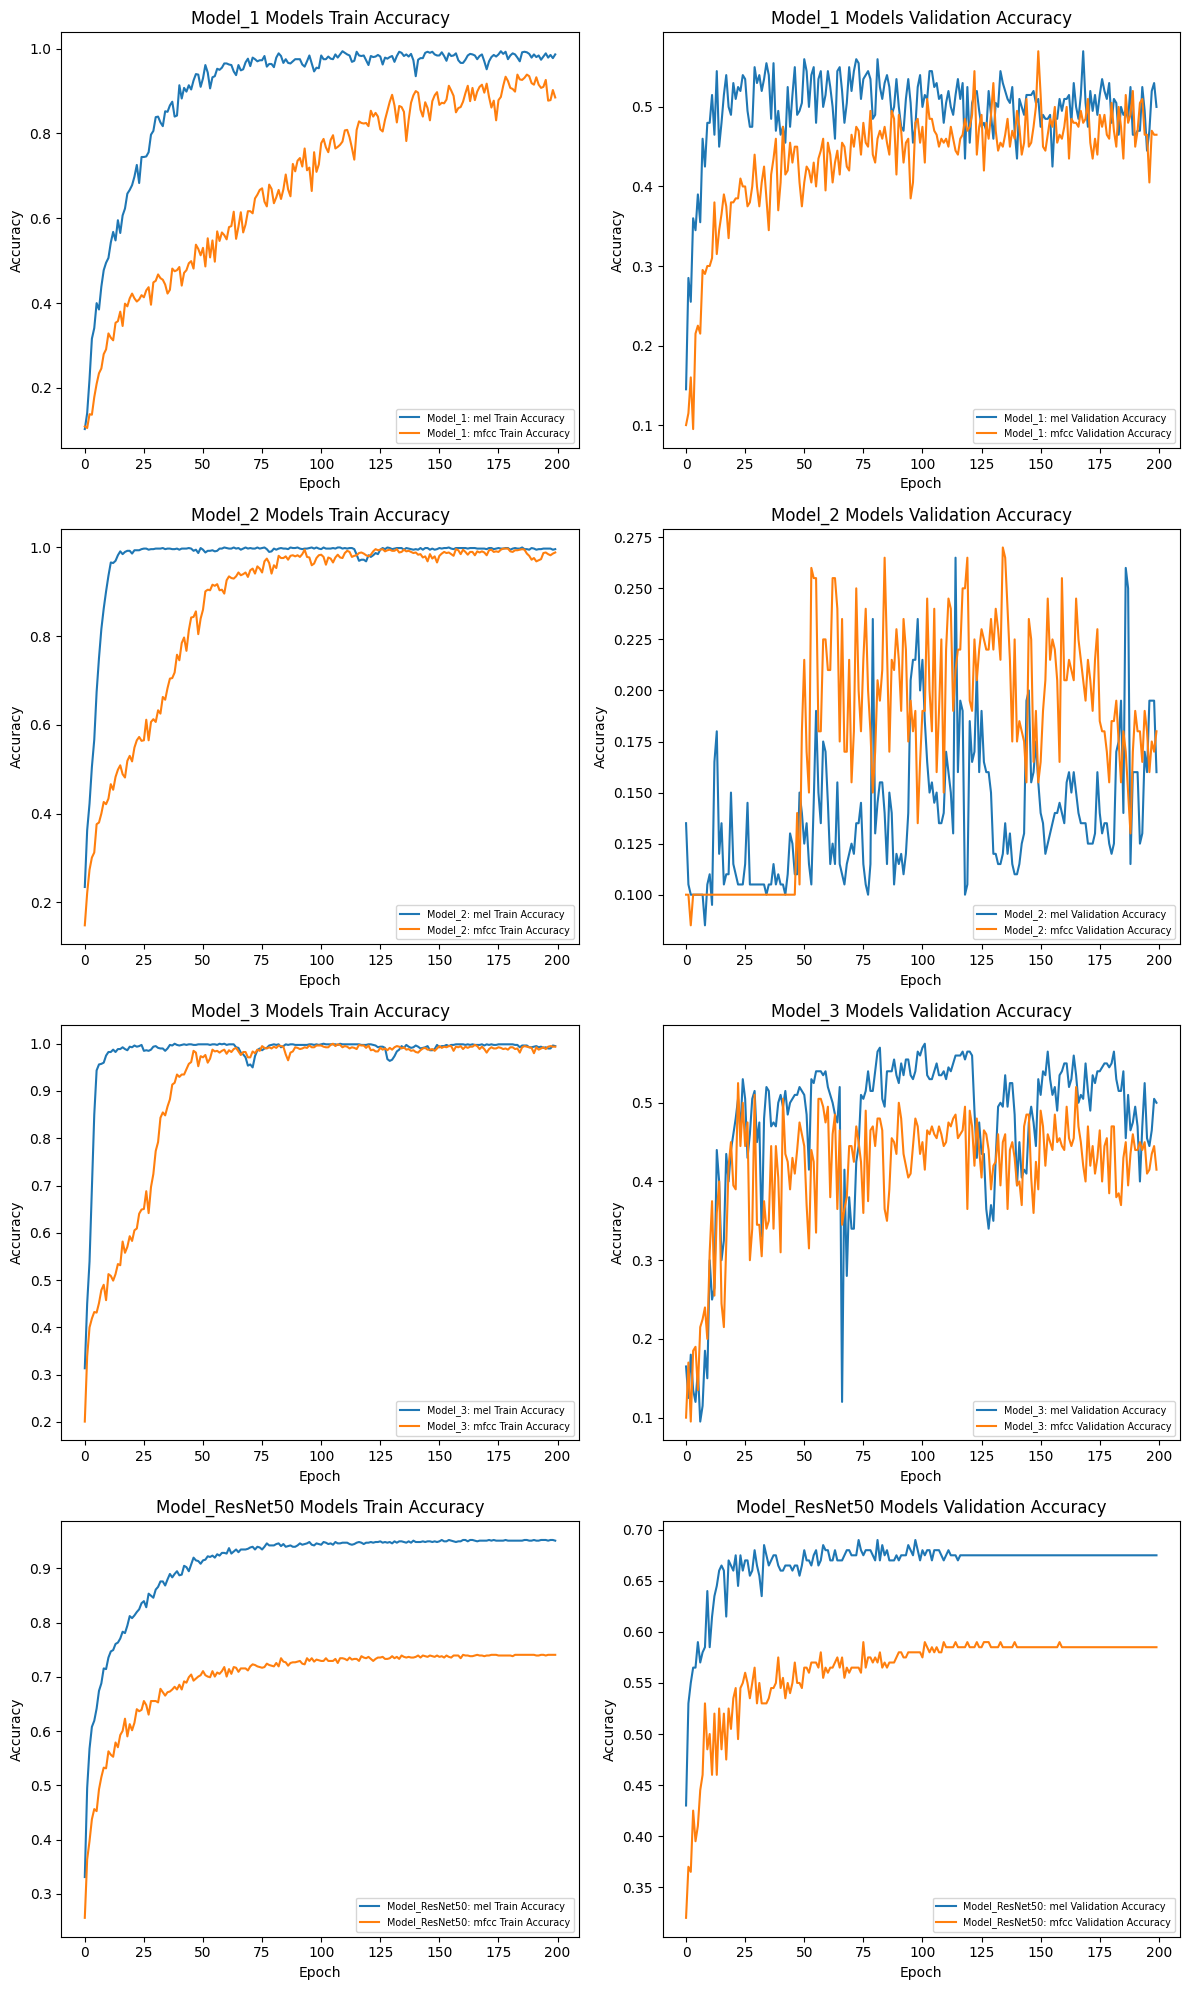

In [ ]:
def plot_combined_history(model_prefix, models_dict, axes):
    ax1, ax2 = axes

    for model in models_dict:
        if model.startswith(model_prefix):
            history = np.load(models_dict.get(model).get('history'), allow_pickle='TRUE').item()
            ax1.plot(history['accuracy'], label=f'{model} Train Accuracy')
            ax2.plot(history['val_accuracy'], label=f'{model} Validation Accuracy')

    ax1.set_title(f'{model_prefix} Models Train Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(fontsize="x-small", loc='lower right')

    ax2.set_title(f'{model_prefix} Models Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend(fontsize="x-small", loc='lower right')

if not models_dict:
  models_dict = np.load("/content/drive/MyDrive/GoogleCollab/Data/GTZAN/checkpoints/model_accuracy_comparision_dict.npy")

fig, axes = plt.subplots(4, 2, figsize=(12, 20))

plot_combined_history('Model_1', models_dict, axes[0])
plot_combined_history('Model_2', models_dict, axes[1])
plot_combined_history('Model_3', models_dict, axes[2])
plot_combined_history('Model_ResNet50', models_dict, axes[3])

plt.tight_layout()
plt.savefig('combined_plots.png')
plt.show()

In [ ]:
for model in models_dict:
  history = np.load(models_dict[model]['history'], allow_pickle='TRUE').item()
  history['accuracy'] = history['accuracy']
  history['val_accuracy'] = history['val_accuracy']

  max_train_acc = max(history['accuracy'])
  max_val_acc = max(history['val_accuracy'])

  print(model, max_train_acc, max_val_acc)

Model_1: mel 0.9937343597412109 0.5699999928474426
Model_1: mfcc 0.9385964870452881 0.5699999928474426
Model_ResNet50: mel 0.9523809552192688 0.6899999976158142
Model_ResNet50: mfcc 0.7406014800071716 0.5899999737739563
Model_3: mel 1.0 0.574999988079071
Model_3: mfcc 1.0 0.5249999761581421
Model_2: mel 1.0 0.26499998569488525
Model_2: mfcc 0.9974937438964844 0.27000001072883606


In [ ]:
spectogram_dir = '/content/drive/MyDrive/GoogleCollab/Data/GTZAN/old_spectrograms/mel_spectrograms'
classes = np.load(os.path.join(spectogram_dir, 'classes.npy'))


models_dict = np.load("/content/drive/MyDrive/GoogleCollab/Data/GTZAN/checkpoints/model_accuracy_comparision_dict.npy", allow_pickle=True)
models_dict = models_dict.item()

for model in models_dict:
  y_pred = models_dict.get(model).get('y_pred')
  y_test = models_dict.get(model).get('y_test')
  accuracy = accuracy_score(y_test, y_pred)
  metrics_f1_score = metrics.f1_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred))
  print(str(model) + " statistics")
  print(f'F1 Score: {metrics_f1_score}')
  print(f'Accuracy: {accuracy:.4f}' + '\n')

Model_1: mel statistics
F1 Score: 0.5503579836634062
Accuracy: 0.5700

Model_1: mfcc statistics
F1 Score: 0.5688657710183973
Accuracy: 0.5700

Model_ResNet50: mel statistics
F1 Score: 0.6905361120123635
Accuracy: 0.6900

Model_ResNet50: mfcc statistics
F1 Score: 0.577362225453281
Accuracy: 0.5900

Model_3: mel statistics
F1 Score: 0.4883447156243384
Accuracy: 0.5000

Model_3: mfcc statistics
F1 Score: 0.4019442221827849
Accuracy: 0.4150

Model_2: mel statistics
F1 Score: 0.0867579908675799
Accuracy: 0.0950

Model_2: mfcc statistics
F1 Score: 0.20325751862289793
Accuracy: 0.1800



# Average split results

In [ ]:
import numpy as np

models_dict1 = np.load("/content/drive/MyDrive/GoogleCollab/Data/GTZAN/checkpoints/Split_1/split_1_accuracy_comparision_dict.npy", allow_pickle=True).item()
models_dict2 = np.load("/content/drive/MyDrive/GoogleCollab/Data/GTZAN/checkpoints/Split_2/split_2_accuracy_comparision_dict.npy", allow_pickle=True).item()
models_dict3 = np.load("/content/drive/MyDrive/GoogleCollab/Data/GTZAN/checkpoints/Split_3/split_3_accuracy_comparision_dict.npy", allow_pickle=True).item()

models_dict = {}

for model in models_dict1:
    y_pred1 = models_dict1.get(model).get('y_pred')
    y_pred2 = models_dict2.get(model).get('y_pred')
    y_pred3 = models_dict3.get(model).get('y_pred')

    if not y_pred1.size == y_pred2.size == y_pred3.size:
      random_index = np.random.randint(0, y_pred1.size)
      random_number_from_y_pred1 = y_pred1[random_index]
      y_pred1 = np.append(y_pred1, random_number_from_y_pred1)

    averaged_y_pred = (y_pred1 + y_pred2 + y_pred3) / 3.0

    y_test1 = models_dict1.get(model).get('y_test')
    y_test2 = models_dict2.get(model).get('y_test')
    y_test3 = models_dict3.get(model).get('y_test')

    if not y_test1.size == y_test2.size == y_test3.size:
      random_index2 = np.random.randint(0, y_test1.size)
      random_number_from_y_test1 = y_test1[random_index2]
      y_test1 = np.append(y_test1, random_number_from_y_test1)

    averaged_y_test = (y_test1 + y_test2 + y_test3) / 3.0

    averaged_y_preds = np.array(np.ceil(averaged_y_pred))
    averaged_y_tests = np.array(np.ceil(averaged_y_test))

    model_dict = {'y_pred': averaged_y_preds, 'y_test': averaged_y_tests}

    models_dict[str(model)] = model_dict


In [ ]:
np.save('average_accuracy_comparision_dict.npy', models_dict)

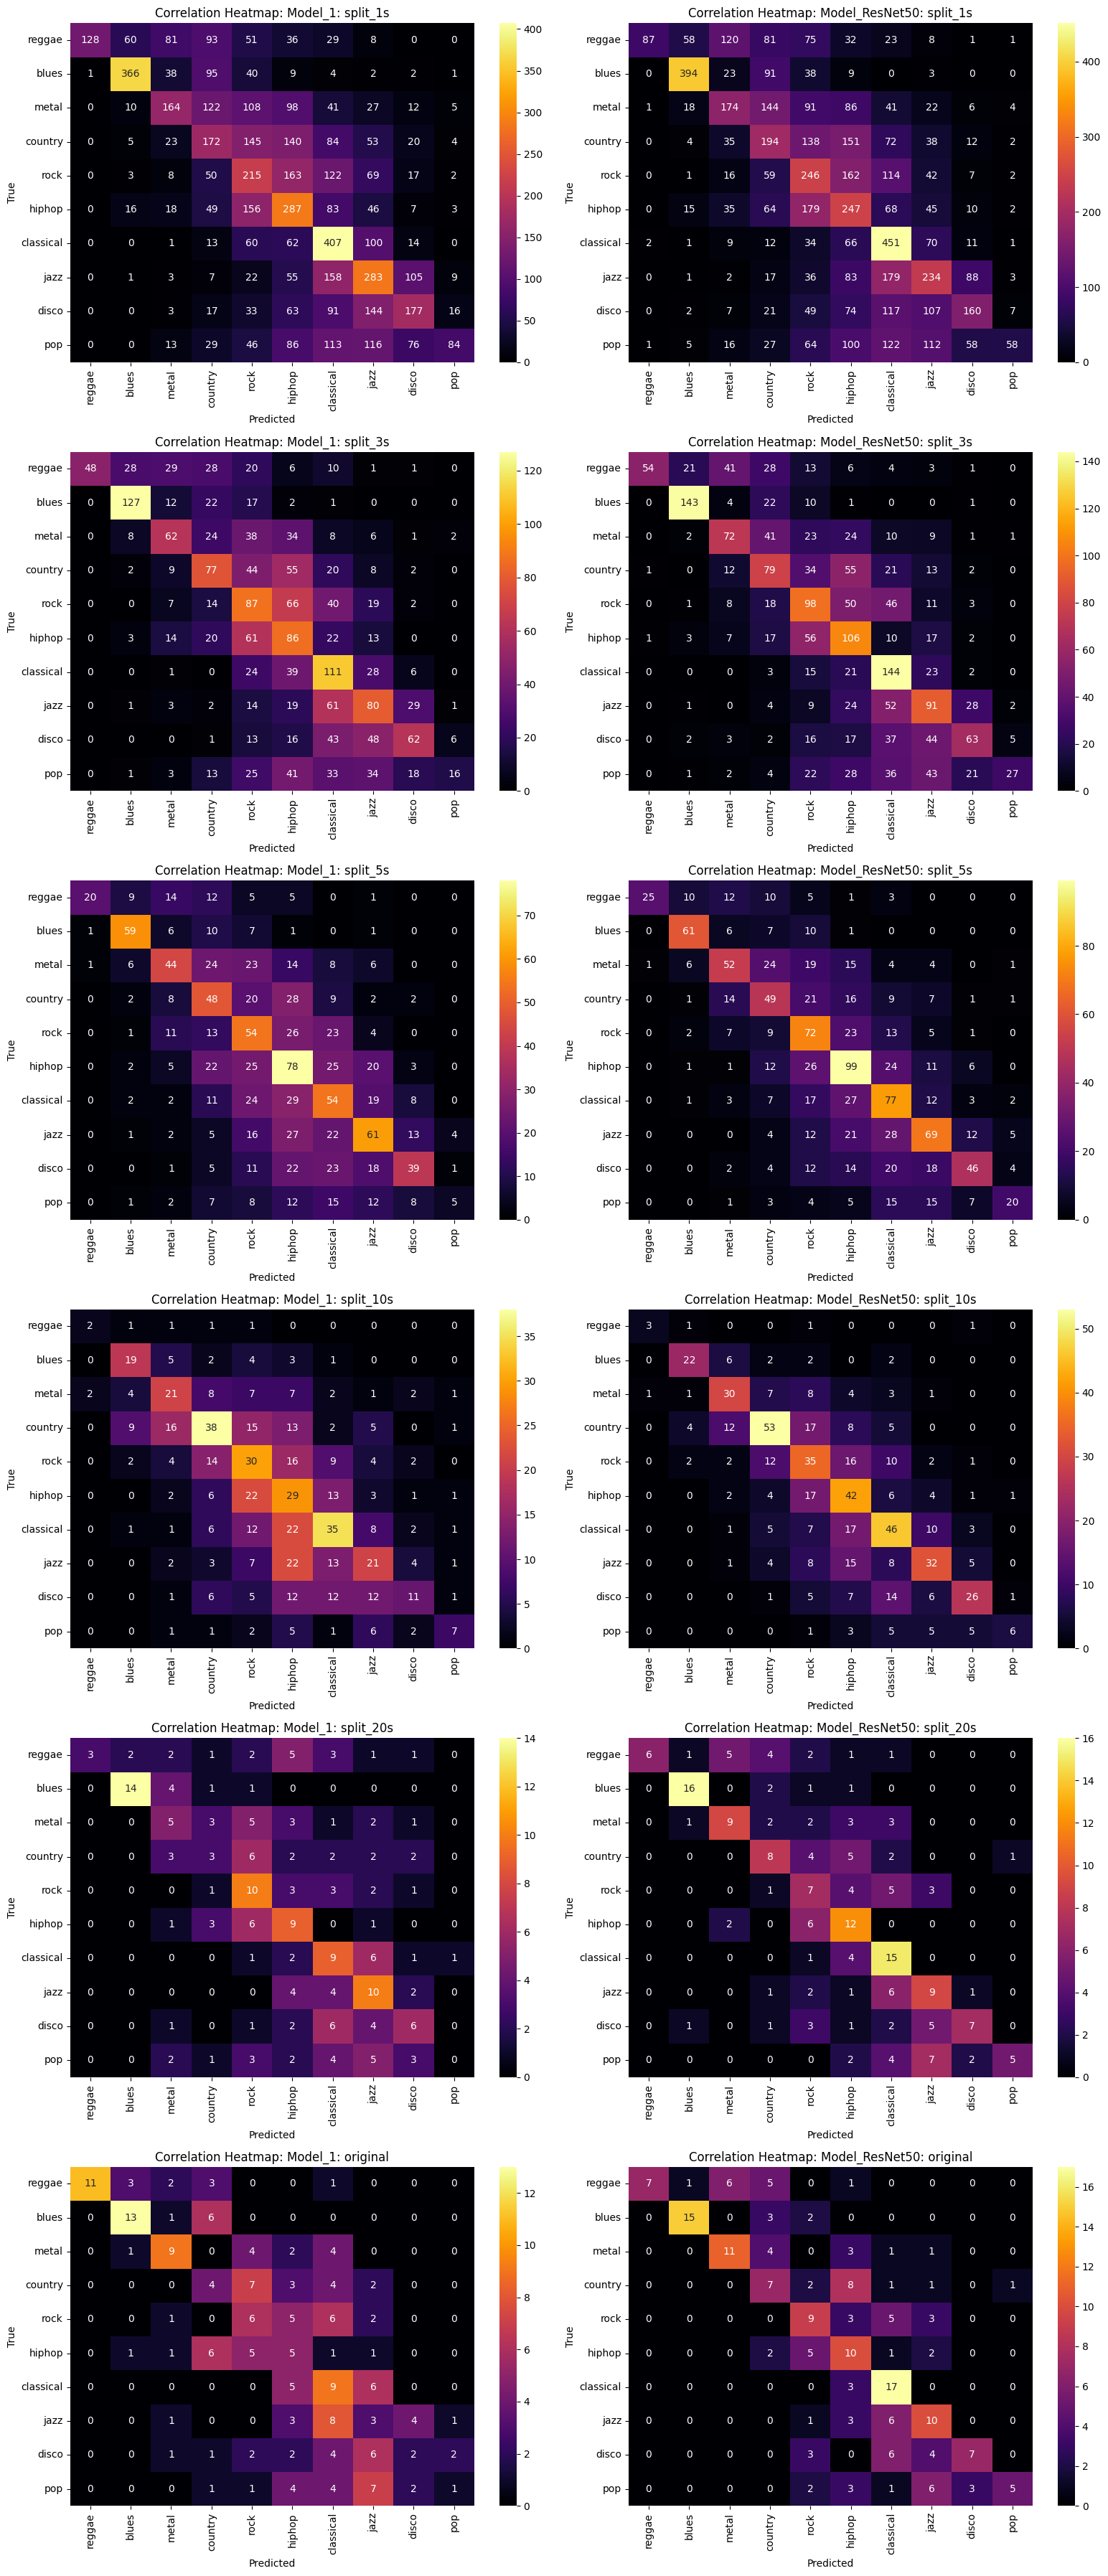

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# models_dict = np.load("/content/drive/MyDrive/GoogleCollab/Data/GTZAN/checkpoints/Split_1/split_1_accuracy_comparision_dict.npy", allow_pickle=True)
# models_dict = models_dict.item()

spectogram_dir = '/content/drive/MyDrive/GoogleCollab/Data/GTZAN/old_spectrograms/mel_spectrograms'
classes = np.load(os.path.join(spectogram_dir, 'classes.npy'))

num_models = len(models_dict)
num_cols = 2
num_rows = (num_models + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 8, num_rows * 6))

for i, model in enumerate(models_dict):
    row = i // num_cols
    col = i % num_cols

    y_pred = models_dict.get(model).get('y_pred')
    y_test = models_dict.get(model).get('y_test')
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='inferno', xticklabels=classes, yticklabels=classes, ax=axes[row, col])
    axes[row, col].set_title('Correlation Heatmap: ' + str(model))
    axes[row, col].set_xlabel('Predicted')
    axes[row, col].set_ylabel('True')

for i in range(num_models, num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.savefig('combined_heatmaps.png')
plt.show()